In [1]:
import pandas as pd
import numpy as np
import re
import gensim
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from wordcloud import WordCloud
from gensim import corpora, models, similarities
import pyLDAvis
from pprint import pprint
import pickle 
import os
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
import random
from gensim.models.ldamodel import LdaModel
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import MmCorpus
import mymodule

In [2]:
data = pd.read_csv('dataset/DatasetLegal.csv')
str_answer = data['answer'].astype(str)
str_answer = str_answer.map(lambda x: re.sub('[,.!?*#/]', '', x))
str_question = data['question'].astype(str)
str_question = str_question.map(lambda x: re.sub('[,.!?*#/]', '', x))
RANDOM_STATE = 100

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/DatasetLegal.csv'

In [ ]:
data.head(5)

,question,answer,Classes
0,!ดิฉันมีเรื่องปรึกษาเกี่ยวกับคดีครอบครัวคือว่า...,ดอกเบี้ยของเงินฝากสินส่วนตัวของภริยาย่อมเป็นดอ...,family
1,#บิดาดิฉันมีลูกติดคนมารดามีลูกติดคน#บิดามารดาส...,คุณสามารถร้องขอเป็นผู้จัดการมรดกของบิดาได้ส่วน...,family
2,#เรื่องการ้ยืมมีคนมายืมเงินได้เขียนสัญญา้้ยืมแ...,เช็คลงวันที่ไม่ตรงกับวันครบกำหนดสัญญา้จะฟ้องร้...,contract
3,๑ผมเป็นบุตรพ่อตามกฎหมาย๒พ่อมีน้อง๑คนยังมีชีวิต...,คุณมีทางเลือกอยู่ประการประการแรกยื่นคำร้องเพื่...,family
4,๑มีคดีบัตรเครดิตตั้งแต่ยุคฟองสบู่แตกประมาณ๑๓ใบ...,คดีที่มีการฟ้องร้องแล้วและศาลอ่านคำพิพากษาเกิน...,contract


In [ ]:
sentense_token = []
for i in range(len(str_answer)):
  sentense_token.append(str_question[i])
  sentense_token.append(str_answer[i])

train_data = sentense_token[:12655]
test_data = sentense_token[12655:]

In [ ]:
word_token_answer = []
for sentense in train_data:
  word = word_tokenize(sentense, engine='newmm')
  word_token_answer.append(word)

In [ ]:
stopwords = list(thai_stopwords())
read_stopwords = pd.read_csv('dataset/add_stopwords.csv')
add_stopwords = read_stopwords['stopword'].values.tolist()
processed_answer = []
for sentense in word_token_answer:
  each_sentense = []
  for word in sentense:
    if(word not in stopwords + add_stopwords):
      each_sentense.append(word)
  processed_answer.append(each_sentense)

In [ ]:
pd.Series(processed_answer)

0        [มีเรื่อง, ปรึกษา, ครอบครัว, สินสมรส, สินส่วนต...
1        [ดอกเบี้ย, เงินฝาก, สินส่วนตัว, ภริยา, ดอกผลนิ...
2        [บิดา, ลูกติด, มารดา, ลูกติด, บิดา, มารดา, สมร...
3        [ร้องขอ, ผู้จัดการมรดก, บิดา, ได้ส่วน, พี่น้อง...
4        [กา, ร้, ยืม, ยืม, เงินได้, สัญญา้้, ยืม, เช็ค...
                               ...                        
12650    [สัว, สดี, พี่ชาย, จับได้, ยาเสพติด, ครอบครอง,...
12651    [ความผิด, ฐาน, มีไว้ในครอบครอง, จำหน่าย, ยาเสพ...
12652    [เรียกร้อง, ค่าเสียหาย, กิน, อาหาร, อาหาร, ปนเ...
12653    [ฟ้องคดี, บริษัทผู้ผลิต, เป็นคดี, ผู้บริโภค, เ...
12654    [สามี, กระทำความผิด, ฆ่า, คนตาย, หนี, จับกุม, ...
Length: 12655, dtype: object

In [8]:
id2word = corpora.Dictionary(processed_answer)
# print(id2word)
with open('model/id2word.pkl', 'wb') as f:
    pickle.dump(id2word, f)

2023-05-09 12:18:37.061 INFO    gensim.corpora.dictionary: adding document #0 to Dictionary<0 unique tokens: []>
2023-05-09 12:18:38.249 INFO    gensim.corpora.dictionary: adding document #10000 to Dictionary<14622 unique tokens: ['กฎหมาย', 'การทราบ', 'การร้องขอ', 'ขอโทษ', 'ข้อตกลง']...>
2023-05-09 12:18:38.737 INFO    gensim.corpora.dictionary: built Dictionary<16276 unique tokens: ['กฎหมาย', 'การทราบ', 'การร้องขอ', 'ขอโทษ', 'ข้อตกลง']...> from 12655 documents (total 633709 corpus positions)
2023-05-09 12:18:38.741 INFO    gensim.utils: Dictionary lifecycle event {'msg': "built Dictionary<16276 unique tokens: ['กฎหมาย', 'การทราบ', 'การร้องขอ', 'ขอโทษ', 'ข้อตกลง']...> from 12655 documents (total 633709 corpus positions)", 'datetime': '2023-05-09T12:18:38.741866', 'gensim': '4.3.0', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


In [9]:
corpus = []
for text in processed_answer:
  vec = id2word.doc2bow(text)
  corpus.append(vec)

In [10]:
pd.Series(corpus)

0        [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
1        [(0, 1), (4, 1), (9, 4), (14, 1), (15, 2), (20...
2        [(57, 1), (84, 1), (85, 1), (86, 1), (87, 2), ...
3        [(5, 1), (49, 3), (66, 1), (84, 1), (92, 1), (...
4        [(6, 1), (9, 1), (11, 2), (13, 1), (22, 1), (4...
                               ...                        
12650    [(23, 1), (28, 3), (202, 1), (260, 2), (261, 1...
12651    [(17, 2), (20, 1), (28, 2), (78, 1), (79, 1), ...
12652    [(391, 1), (741, 1), (762, 1), (789, 1), (1867...
12653    [(415, 1), (781, 1), (931, 1), (1103, 1), (153...
12654    [(28, 2), (33, 3), (109, 1), (208, 1), (260, 1...
Length: 12655, dtype: object

In [11]:
num_topics = 6
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            iterations=100,
                                            chunksize=2000,
                                            passes=1,
                                            alpha='auto',
                                            eta='auto',
                                            random_state=RANDOM_STATE,
                                            update_every=0,
                                            minimum_probability=0,
                                            eval_every=1
                                            )

2023-05-09 12:18:40.283 INFO    gensim.models.ldamodel: using autotuned alpha, starting with [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667]
2023-05-09 12:18:40.295 INFO    gensim.models.ldamodel: using serial LDA version on this node
2023-05-09 12:18:40.333 INFO    gensim.models.ldamodel: running batch LDA training, 6 topics, 1 passes over the supplied corpus of 12655 documents, updating model once every 12655 documents, evaluating perplexity every 2000 documents, iterating 100x with a convergence threshold of 0.001000
2023-05-09 12:18:40.334 WARNING gensim.models.ldamodel: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-05-09 12:18:48.627 INFO    gensim.models.ldamodel: -10.394 per-word bound, 1345.3 perplexity estimate based on a held-out corpus of 2000 documents with 97236 words
2023-05-09 12:18:48.629 INFO    gensim.models.ldamodel: PROGRESS: pass 0, at document #2000/12655
2023-

In [12]:
with open('model/lda_model.pkl', 'wb') as f:
    pickle.dump(lda_model, f)
    

In [23]:
with open('model/lda_model.pkl', 'rb') as f:
    lda_model = pickle.load(f)
lda_model.show_topics(num_topics=6, num_words=10)

[(0,
  '0.013*"พ่อ" + 0.011*"มาตรา" + 0.011*"ที่ดิน" + 0.011*"บ้าน" + 0.010*"จ่าย" + 0.010*"เงิน" + 0.008*"สิทธิ" + 0.007*"กรณี" + 0.006*"ศาล" + 0.006*"โอน"'),
 (1,
  '0.012*"จ่าย" + 0.011*"ฟ้อง" + 0.010*"เงิน" + 0.009*"ศาล" + 0.009*"สัญญา" + 0.009*"รถ" + 0.008*"จำเลย" + 0.007*"บาท" + 0.006*"ทราบ" + 0.006*"บ้าน"'),
 (2,
  '0.015*"ศาล" + 0.013*"รถ" + 0.010*"บาท" + 0.009*"สัญญา" + 0.008*"เงิน" + 0.007*"เช่าซื้อ" + 0.007*"ที่ดิน" + 0.006*"บ้าน" + 0.006*"สิทธิ" + 0.006*"บิดา"'),
 (3,
  '0.013*"สามี" + 0.012*"เงิน" + 0.011*"บุตร" + 0.010*"บ้าน" + 0.010*"บริษัท" + 0.007*"ฟ้อง" + 0.007*"ศาล" + 0.006*"เด็ก" + 0.006*"จ่าย" + 0.006*"สัญญา"'),
 (4,
  '0.018*"มาตรา" + 0.017*"ศาล" + 0.009*"แม่" + 0.008*"สิทธิ" + 0.007*"บุตร" + 0.006*"ที่ดิน" + 0.006*"ฟ้อง" + 0.006*"สัญญา" + 0.005*"จ่าย" + 0.005*"สามี"'),
 (5,
  '0.016*"ที่ดิน" + 0.016*"บริษัท" + 0.012*"นายจ้าง" + 0.011*"สิทธิ" + 0.010*"มาตรา" + 0.008*"ลูกจ้าง" + 0.007*"ลูก" + 0.006*"กรณี" + 0.006*"ทำงาน" + 0.006*"ฟ้อง"')]

In [14]:
import pickle
topic_dict = {
    0 : "succession",
    1 : "labor",
    2 : "criminal",
    3 : "violation",
    4 : "family",
    5 : "contract"
}

with open('model/topic_dict.pkl', 'wb') as f:
    pickle.dump(topic_dict, f)


In [15]:
import pyLDAvis.gensim_models as gensimvis
num_topics = 6
with open('model/id2word.pkl', 'rb') as f:
  id2word = pickle.load(f)
with open('model/lda_model.pkl', 'rb') as f:
  lda_model = pickle.load(f)
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(num_topics))

LDAvis_data_filepath
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\User\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.036603 -0.004329       1        1  20.965416
3     -0.002266  0.032158       2        1  20.619525
2      0.051246 -0.017343       3        1  16.557694
4     -0.015150 -0.032162       4        1  16.150969
1      0.016264  0.020446       5        1  13.574129
0     -0.013490  0.001231       6        1  12.132266, topic_info=        Term         Freq        Total Category  logprob  loglift
125      พ่อ  2445.000000  2445.000000  Default  30.0000  30.0000
395       รถ  3327.000000  3327.000000  Default  29.0000  29.0000
20     มาตรา  5416.000000  5416.000000  Default  28.0000  28.0000
28       ศาล  6074.000000  6074.000000  Default  27.0000  27.0000
651  นายจ้าง  3577.000000  3577.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
28       ศาล   487.572189  6074.810990   Topic6  -5.0606  -0.4132
77     สัญญา   391.364093  3886.011930   Topic6  -5.2804  -0.1862
262     ทราบ   326.428085  2870.355976   Topic6  -5.4618  -0.0647
17       บาท   320.326354  3699.982737   Topic6  -5.4807  -0.3374
391   บริษัท   309.911859  4681.066614   Topic6  -5.5138  -0.6057

[562 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
15799      6  0.749702            +พอ
12430      4  0.685483              ~
0          1  0.190702         กฎหมาย
0          2  0.203331         กฎหมาย
0          3  0.124398         กฎหมาย
...      ...       ...            ...
2830       3  0.023121              “
2830       4  0.468192              “
2830       5  0.075142              “
2830       6  0.034681              “
4629       2  0.851616  …………………………………

[1489 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 3, 5, 2, 1])

The sections below working on lda model in question part

In [16]:
sentense_token_question = []
# for each_question in str_question:
#   sentense_token_question.append(each_question)
for i in range (6328):
  sentense_token_question.append(str_question[i])
# print(len(question_data))
topic_question = []
corpus_question = []
for sentense in sentense_token_question:
  processed_question = mymodule.preprocess(sentense)
  corpus_question.append(processed_question)
  topic = lda_model.get_document_topics(processed_question)
  topic_question.append(topic)

In [17]:
with open('model/question_lda.pkl', 'wb') as f:
    pickle.dump(topic_question, f)
MmCorpus.serialize('model/corpus_question.mm', corpus_question)

2023-05-09 12:23:53.920 INFO    gensim.corpora.mmcorpus: storing corpus in Matrix Market format to model/corpus_question.mm
2023-05-09 12:23:53.928 INFO    gensim.matutils: saving sparse matrix to model/corpus_question.mm
2023-05-09 12:23:53.929 INFO    gensim.matutils: PROGRESS: saving document #0
2023-05-09 12:23:54.025 INFO    gensim.matutils: PROGRESS: saving document #1000
2023-05-09 12:23:54.132 INFO    gensim.matutils: PROGRESS: saving document #2000
2023-05-09 12:23:54.222 INFO    gensim.matutils: PROGRESS: saving document #3000
2023-05-09 12:23:54.324 INFO    gensim.matutils: PROGRESS: saving document #4000
2023-05-09 12:23:54.419 INFO    gensim.matutils: PROGRESS: saving document #5000
2023-05-09 12:23:54.532 INFO    gensim.matutils: PROGRESS: saving document #6000
2023-05-09 12:23:54.568 INFO    gensim.matutils: saved 6328x16276 matrix, density=0.220% (226744/102994528)
2023-05-09 12:23:54.570 INFO    gensim.corpora.indexedcorpus: saving MmCorpus index to model/corpus_questi

The sections below are in the process of being updated with new documents.

In [18]:
new_doc = random.choice(test_data)
print(new_doc)
test_doc = mymodule.preprocess(new_doc)
print(test_data.index(new_doc))
print(len(test_data))

หมิ่นประมาทก็แจ้งความข้อหาหมิ่นประมาทตามปอมมีโทษจำคุกสองปีปรับสองแสนบาทแจ้งณโรงพักที่เปิดพบหมิ่นประมาท
1182
1407


In [19]:
with open('model/question_lda.pkl', 'rb') as f:
    topic_question = pickle.load(f)
with open('model/topic_dict.pkl', 'rb') as f:
    topic_dict = pickle.load(f)
new_doc_topics = lda_model.get_document_topics(test_doc)
new_doc_topics_dict = {topic_dict[topic]: prob for topic, prob in new_doc_topics}
print(new_doc_topics_dict)

{'succession': 0.0026002598, 'labor': 0.0026207578, 'criminal': 0.002456634, 'violation': 0.98590815, 'family': 0.0030139924, 'contract': 0.0034002052}


Text(0.5, 1.0, 'topic distribution for document')

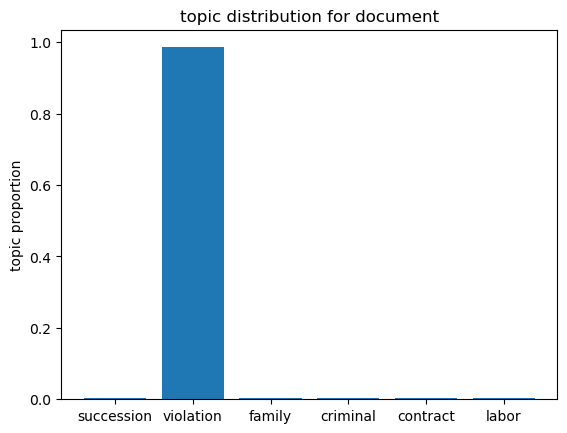

In [20]:
x = ['succession', 'violation', 'family', 'criminal', 'contract', 'labor']
y = [new_doc_topics_dict[i] for i in x]
plt.bar(x,y)
plt.ylabel('topic proportion')
plt.title(f'topic distribution for document')

In [21]:
# print(index)
# print(corpus_lda)
# print(sims)

In [22]:
corpus = corpus_question
data = pd.read_csv('dataset/DatasetLegal.csv')
with open('model/id2word.pkl', 'rb') as f:
  id2word = pickle.load(f)
corpus_lda = lda_model[corpus]
index = similarities.MatrixSimilarity(corpus_lda, num_features=len(id2word))
sims = index[new_doc_topics]
sims_sorted = sorted(enumerate(sims), key=lambda item: -item[1])
print(f"Topic distribution for new document : {new_doc_topics}\n{new_doc}\n")
for doc_id, similarity in sims_sorted[:5]:
  print(f"Document ID: {doc_id}, Similarity score: {similarity}")
  print(data.answer[doc_id])
  print("Topic distribution for similar document : ")
  for num, dis in corpus_lda[doc_id]:
    print(f"\t({topic_dict.get(num)}, {'%.5f' %dis})")

2023-05-09 12:23:56.628 INFO    gensim.similarities.docsim: creating matrix with 6328 documents and 16276 features


Topic distribution for new document : [(0, 0.0026002598), (1, 0.0026207578), (2, 0.002456634), (3, 0.98590815), (4, 0.0030139924), (5, 0.0034002052)]
หมิ่นประมาทก็แจ้งความข้อหาหมิ่นประมาทตามปอมมีโทษจำคุกสองปีปรับสองแสนบาทแจ้งณโรงพักที่เปิดพบหมิ่นประมาท

Document ID: 46, Similarity score: 1.0
พินัยกรรมจะมีผลบังคับได้ต่อเมื่อพ่อแม่ผู้ทำพินัยกรรมไว้ถึงแก่กรรมแล้วอย่างไรก็ตามแม่สามีจะได้รับมรดกตามพินัยกรรมย่อมเป็นสินส่วนตัวของสามีไม่ใช่สินสมรส
Topic distribution for similar document : 
	(succession, 0.00260)
	(labor, 0.00262)
	(criminal, 0.00246)
	(violation, 0.73693)
	(family, 0.00301)
	(contract, 0.25238)
Document ID: 590, Similarity score: 1.0
เป็นอำนาจของเจ้าพนักงานตำรวจเมื่อมีความสงสัยตามสมควรว่าบุคคลนั้นได้กระทำความผิดเจ้าพนักงานตำรวจย่อมมีอำนาจดำเนินการตรวจปัสสาวะตามปวิอมาตราได้และไม่เป็นการอนาจาร
Topic distribution for similar document : 
	(succession, 0.00261)
	(labor, 0.00263)
	(criminal, 0.00246)
	(violation, 0.98588)
	(family, 0.00302)
	(contract, 0.00341)
Document ID: 835, Sim